In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import lightning.pytorch as pl

print(torch.cuda.is_available())

True


## Import Datasets

In [2]:
# download and import data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Build a Lightning Model

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
# create model class from pl.LightningModule
class LitNeuralNetwork(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        pred = self.forward(x)
        loss = F.cross_entropy(pred, y)
        
        self.log("train_loss",loss)
        tensorboard_logs = {'train_loss': loss}
        return {"loss": loss, "log": tensorboard_logs}
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        pred = self.forward(x)
        loss = F.cross_entropy(pred, y)
        
        self.log("val_loss",loss)
        return {"val_loss":loss}

In [15]:
# model instantiate
model = LitNeuralNetwork()
model

LitNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [7]:
# we didnt need train/test loop, just use trainer class from lightning
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | flatten           | Flatten    | 0     
1 | linear_relu_stack | Sequential | 669 K 
-------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 938/938 [00:19<00:00, 48.02it/s, v_num=1]        

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:19<00:00, 47.96it/s, v_num=1]


In [9]:
# see training logs with tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Testing Model

In [11]:
# load model base on training checkpoint
checkpoint_path = 'lightning_logs/version_1/checkpoints/epoch=9-step=9380.ckpt'
loaded_model = LitNeuralNetwork.load_from_checkpoint(checkpoint_path)

Predicted: "Bag", Actual: "Bag"


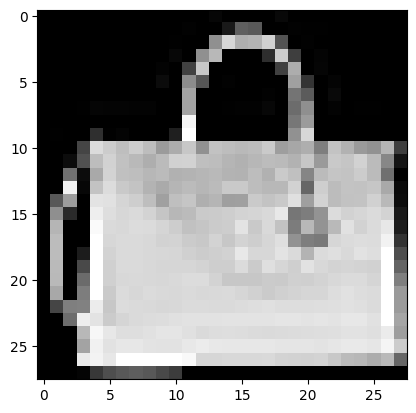

In [14]:
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

loaded_model.eval()
data_id = 30
x, y = test_data[data_id][0], test_data[data_id][1]
with torch.no_grad():
    x = x.to(device)
    pred = loaded_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    plt.imshow(x.cpu().numpy().squeeze(), cmap="gray")